In [1]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pymc as pm
from scipy import stats
import seaborn as sns
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# The Grand Slam Tellers:
Shen Wang , 002697074, wang.shen3@northeastern.edu </br>
Amey Parangr, 002791448, parange.a@northeastern.edu </br>
Neha Bhutkar, 002722457, bhutkar.n@northeastern.edu </br>



In [2]:
Grand_Slam_Tellers={
    'name':['Shen Wang', 'Amey Parangr','Neha Bhutkar'],
    'NUID':['002697074','002791448',', 002722457'],
    'Email':['wang.shen3@northeastern.edu','parange.a@northeastern.edu','bhutkar.n@northeastern.edu']
}
df_Grand_Slam_Tellers=pd.DataFrame(Grand_Slam_Tellers)
df_Grand_Slam_Tellers

,name,NUID,Email
0,Shen Wang,002697074,wang.shen3@northeastern.edu
1,Amey Parangr,002791448,parange.a@northeastern.edu
2,Neha Bhutkar,", 002722457",bhutkar.n@northeastern.edu


In [3]:
url_atp_matches_2020="https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2020.csv"
df_single = pd.read_csv(url_atp_matches_2020)
url_atp_matches_doubles_2020="https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_doubles_2020.csv"
df_double =pd.read_csv(url_atp_matches_doubles_2020)
#url_atp_players="https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_players.csv"
#df_atp_players = pd.read_csv(url_atp_players)

# the G Level Grand Slam games   

The four Grand Slam tournaments are the Australian Open in January, the French Open from late May to early June, Wimbledon in late June to early July, and the US Open in August–September, with each played over two weeks. The Australian and the United States tournaments are played on hard courts, the French on clay, and Wimbledon on grass. Wimbledon is the oldest tournament, founded in 1877, followed by the US in 1881, the French in 1891, and the Australian in 1905, but it was not until 1925 that all four were held as officially sanctioned majors.   
https://en.wikipedia.org/wiki/Grand_Slam_(tennis)   

In [4]:
# From the single game data, get the count of games won by the players
# For pandas dataframe, we can use df.loc[] method to generate a new selected df.
# usage: df.loc[dim1, dim2,...] 
# for each dimension, we can use a boolean list, such as "df['keyName']=='keyValue'" or a truncating tool ":" to specify the selection
df_wins=df_single.loc[df_single['tourney_level']=='G',:].groupby(['winner_name'])[['winner_age',]].count()
# change the colume names
df_wins.columns=['win_count']
# change the index colume names
df_wins.index.rename('player_name',inplace=True)
df_wins
#there are 310 players who won at least one game in 2020
#there are 122 players who won at least one "G" level grand slam games in 2020

,win_count
player_name,
Adrian Mannarino,2
Albert Ramos,1
Alejandro Davidovich Fokina,5
Alejandro Tabilo,1
Alex Bolt,1
...,...
Tommy Paul,3
Ugo Humbert,1
Vasek Pospisil,3


In [5]:
# From the single game data, get the count of games lost by the players
df_loss=df_single.loc[df_single['tourney_level']=='G',['loser_name','tourney_id',]].groupby(['loser_name'])[['tourney_id',]].count()
# change the colume names
df_loss.columns=['los_count']
# change the index colume names
df_loss.index.rename('player_name',inplace=True)
df_loss
# turns out that there are 310 players who lost at least one game in 2020
# and there are 174 players who lost at least one game in the grand slams in 2020

,los_count
player_name,
Adrian Mannarino,3
Albert Ramos,3
Alejandro Davidovich Fokina,3
Alejandro Tabilo,1
Aleksandar Vukic,1
...,...
Vasek Pospisil,3
Yasutaka Uchiyama,3
Yen Hsun Lu,1


In [6]:
# merge the 2 DataFrames (wins and loss), 
# and know that there are some players who had only lost games without any victories, making the df_loss longer than df_wins
# fill the vacancy of winning spot of these players with 0
df_G_players=pd.concat([df_wins,df_loss],axis=1,join='outer').fillna(0)
# and then find the sum of win and los and add to the 3rd column
df_G_players=pd.concat([df_G_players,df_G_players.sum(axis=1)],axis=1)
# rename the 3rd columns
df_G_players.columns=['win_count','los_count','game_count']
# show the new df_G_players
print(type(df_G_players))
df_G_players

<class 'pandas.core.frame.DataFrame'>


,win_count,los_count,game_count
player_name,,,
Adrian Mannarino,2.0,3,5.0
Albert Ramos,1.0,3,4.0
Alejandro Davidovich Fokina,5.0,3,8.0
Alejandro Tabilo,1.0,1,2.0
Alex Bolt,1.0,1,2.0
...,...,...,...
Thiago Seyboth Wild,0.0,1,1.0
Tomas Machac,0.0,1,1.0
Ulises Blanch,0.0,1,1.0


In [7]:
# Make a new df of the probability to win by win_count/game_count
# df_G_p, G means "Grand Slam", "p" means "probability"
df_G_p = df_G_players['win_count'].div(df_G_players['game_count'],axis=0)
df_G_p=pd.DataFrame(df_G_p)
df_G_p.columns=['win_rate']
print(type(df_G_p))
#df_G_p.plot.barh(height=0.5)

#plt.ylabel('play_name')
#plt.yticks(df_G_p.index[:,1])


<class 'pandas.core.frame.DataFrame'>


<AxesSubplot: ylabel='player_name'>

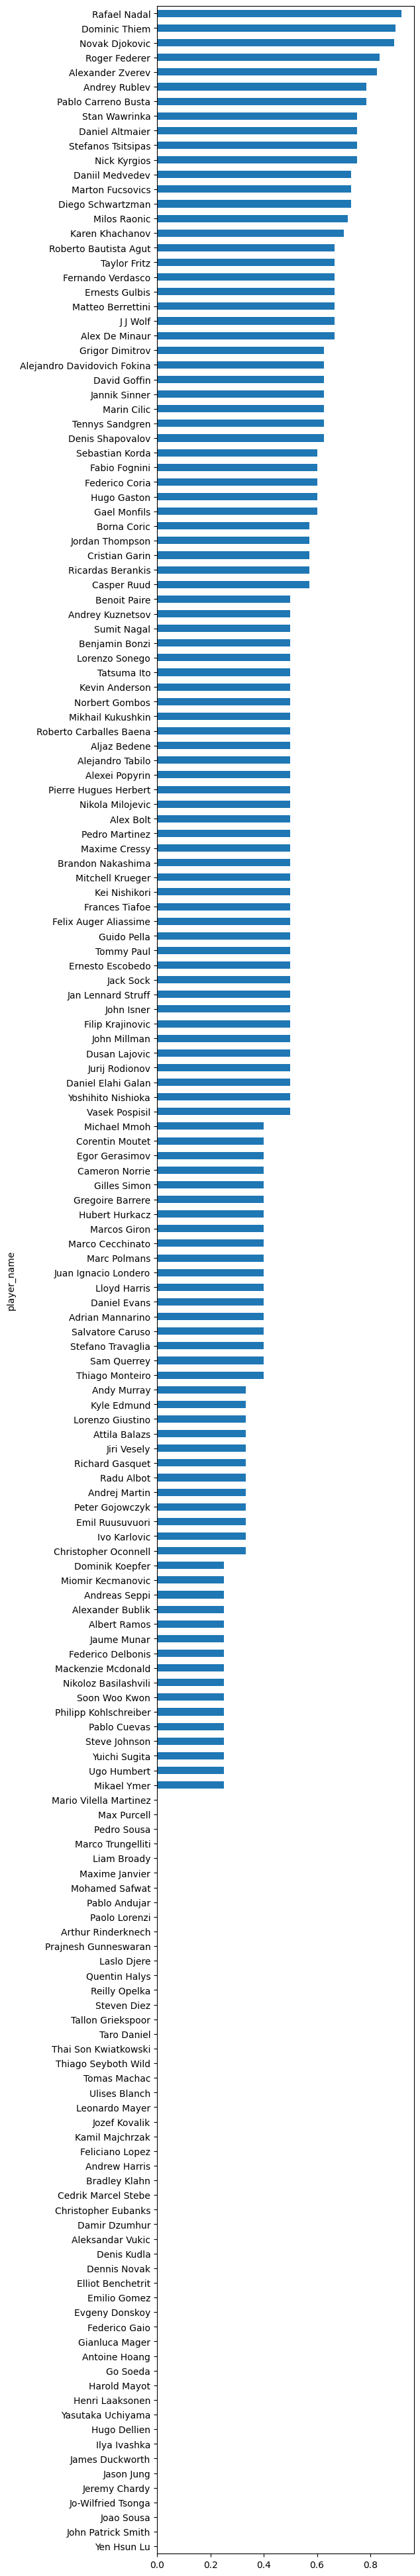

In [8]:
# Plot the win rate of all G level players
df_G_p['win_rate'].sort_values(ascending=True).plot.barh(figsize=(5,50))



# Neha please help: 
1. Can you find a way to improve this plot, for example: adding axis names, legends, axis titles, </br>
2. Will you come up with a way to devide the player into 7 ranks? </br>
    The threshold for each rank shall be 0/7, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7 .

The players:

array([[<AxesSubplot: title={'center': 'win_rate'}>]], dtype=object)

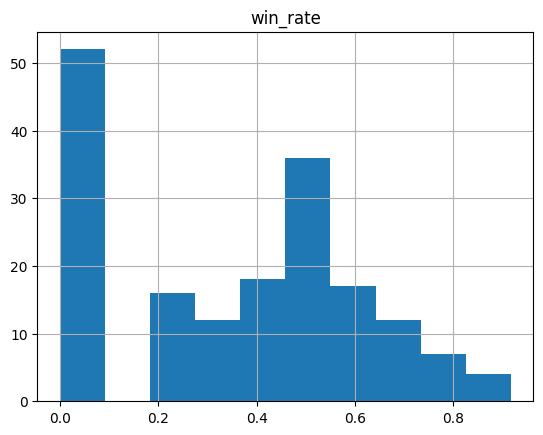

In [9]:
# The distribution of the win rate can be observed by the histogram

df_G_p.hist()
# 

We see that the top rank players has win rate over 80%, but only very few of them are in this rank.<br>
Among the players who can win, the mode is 50% win rate, meaning, most players will win and lose half-half.<br>
And there are a big numbers of players who cannot win any game. They are certainly really good players to qualify for level G.<br>
This tells us how exciting the Level G games are.<br>

# Modeling, Step 1,   Choosing an appropriate distribution</br>
We will use the win_rate of all the Grand Slam players as our prior, in our Beyesian model</br>
But for the model distribution, we have some problem: </br>
There are many players who get no wins in the whole year. It's sad. But it makes our data's histogram look wierd.</br>
There is a high accumulation on zero win rate. This does not mean that these players are not good enough, only that they are not fortunate enough.</br>
We need to take care of this very high population of zero win rate players in our model. </br>
Looking through all the discrete distributions in PyMC5.1.2, we found the wonderful **Zero-Inflated Binomial** distriution.</br>
This distribution is an improvement to a conventional binomial distribution. And it is perfect for our data here.</br>
For 2 reasons:</br>
1. Beside the conventional parameters p (win rate) and n (total games played), there is another parameter **psi** introduced. </br> 
**psi** represents the probability that a player will get at least one win, to be included in the binomial distribution.</br>
In another word, **1-psi** represents the probability that a player will get no win at all.</br>
2. The win rate of a player is actually not a continuous distribution, but discrete. It is calculated by win_counts/all_games.</br>
In one year, the maximum number of Grand Slam games one player can play is 4*7 = 28 games. There are limited number of win rate we can get.</br>
If each game is a Bernoulli event, then the total number of wins out of 7 games is naturally a binomial distribution. </br>

In [10]:
with pm.Model() as zib_model:
    zib_dist=pm.ZeroInflatedBinomial('zib_dist',psi=0.7,p=0.5,n=7)

In [11]:
# draw 1000 posterior samples
with zib_model:
    zib_dist_sample_data = pm.sample(500,chains=1)

Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 0 seconds.


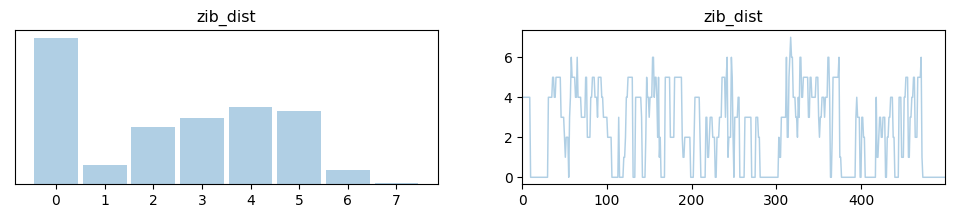

In [12]:
az.plot_trace(zib_dist_sample_data, combined=True);


Looking at the sample above, we are excited that **the zero-inflated binomial distribution is able to resemble the histogram of our win rate data**.

# Amey please help:
1. Can you find a way to build a pandas dataframe with hierachical index to show the ranks Neha comes up with?</br> 
It will be an exciting demonstration of the top norch tennis players, I think. It's for educating ourselves. </br>

# Modeling, Step 2: setting up PyMC parameters
 We will use Zero-inflated Binomial distribution to model the win rate of all the players.</br>
 Zero-inflated Binomial distribution has 3 parameters: psi, p and n</br>
 The parameter **psi** is the over-dispersion parameter, indicating the Expected proportion of Binomial (non-zero) variates; </br>
 The parameter **p** represents the probability of success for each trial; </br>
 The parameter **n** represents the total number of trials.</br>

 In this model, **psi**, **p**, are both non-deterministic, as we do not know how many players will win no game, and how the average win rate shall be.
 But **n** shall be a constant 7. </br>
 Because in a read Grand Slam game there are 128 draws, </br>
 and 4 round-robin tournament games (rr) + 1 quater final (qf) + 1 semi final (sf) + 1 final (f) = 7 games </br>

#### A discussion about  **psi**</br>

The meaning of **PSI** is the ratio of players who can win at least one game out of 7. </br>
In a 128-draw game, 64 players will be knocked out after the 1st round and will have no win. The ratio is 1/2. </br>
If there is only 1 Grand Slam game, psi = 0.5, it is deterministic.</br>
But there are 4 Grand Slam games every year. </br> 
And sometimes 3, such as the year 2020. Because of COVID-19 pandemic, the Wimbledon Championship was cancelled. </br>
https://www.cnn.com/2020/04/01/tennis/wimbledon-canceled-coronavirus-2020-spt-intl/index.html</br>
If a player only join one Grand Slam game, his chance of getting no win will be 50%.</br>
If he joins 2 Grand Slam games, his chance of getting no win will become 50%*50% = 25%. </br>
If he joins all 4 games, this chance is lowered to 1/16 = 7.25%. </br>
But there are too many different factors on this number, making it hard to predict. </br>
At least, we can find out what psi is for 2020, with only 3 Grand Slam games.</br>


In [13]:
# To find out psi, we would find out how may players did win at least one game
# because psi represents the proportion of the binomial part
n_have_win = df_G_p[df_G_p['win_rate']!=0].count() # 
print("n_have_win: ", int(n_have_win)) # = 122
# And find the total number of players
n_all_players = df_G_p.count()
print("n_all_players: ", int(n_all_players)) # = 174
# the value of psi suggested by the data
psi_observed = float(n_have_win/n_all_players)
print('psi_observed: ', psi_observed) # approximately 0.7

n_have_win:  122
n_all_players:  174
psi_observed:  0.7011494252873564


Therefore, it is reasonable to model psi as a distribution.</br>
This distrinution will have a mean value of 0.7, and it should be very likely to be around this number. </br>
Meaning, the standard deviation shall be very small. </br>
It's natural to use a normal distribution to describe such a quantity.</br>

In [14]:
with pm.Model() as win_rate_2020_model:
    psi_2020 = pm.Normal('psi_2020',mu = 0.7,sigma = 0.05)

#### A discussion about  **p**</br>
The probability for a player to win a game in a Grand Slam game is for sure not deterministic. </br>
In fact, this probability varies a lot, depending on the players and the opponents they meet, and the round in the game. </br>
Seed players have much higher probabilities to win a game, than non seeded players. </br>
And sometimes, odd event happens...</br>
Novak Djokovic knocked out of Wimbledon by Sam Querrey</br>
https://www.theguardian.com/sport/2016/jul/02/novak-djokovic-knocked-out-wimbledon-sam-querrey</br>
So, we have no idea what this p will be. It can be anything from 0-1.</br>
But consider p as an average quantity of all players, a reasonable central tendency shall be 0.5. </br>
Because if the probability Novak Djokovic beats Sam Querrey is as high as 99%,</br>
then the probability Sam Querrey beats Novak Djokovic is 1%, which did happen.</br> 
And the average probability between them 2 will be (1%+99%)/2=50%!</br>
And these 2 probability shall be equally distant to 50%.</br>
This makes Student's T distribution a good candidate to represent the distribution of win rate **p**.</br>
For 2 reasons as well:</br>
    1. Student's T distribution is an improvement to normal distribution. It has a symmetric distribution around the peak.</br>
    2. Student's T distribution is designed to allow values far off the average to appear. So that Sam Querrey will have fair opportunity to beat Djokovic the first round.</br>

Considering that we do not know how dispersed the win rate shall be from 50%, it is reasonable to model the sigma as a distribution where we do not have any knowledge. The uniform distribution.</br>
Hence, we adopted a hierachical model.</br>

In [15]:
with win_rate_2020_model:
    sigma4p_2020 = pm.Uniform('sigma4p_2020',lower=0.01, upper=0.5)
    p_2020 = pm.StudentT('p_2020',nu=5, mu=0.5, sigma=sigma4p_2020)


Here, we need to pay attention to value of nu. It's set nu =5.</br>
In the previous study, i. e. our homework assignment 10, we have already stated that </br>
for Student's T distribution, when the dimensional parameter nu <= 1, the distribution will not be able to coverge and normalize. </br>
We learned from "Bayesian Analysis with Python_ Introduction to statistical modeling and probabilistic programming using PyMC3 and ArviZ" </br>
by Osvaldo Martin, page 59 (https://www.amazon.com/Bayesian-Analysis-Python-Osvaldo-Martin/dp/1785883801) </br>
that <mark>"A very curious feature of the Student's t- distribution is that it has no defined mean when nu<=1"</mark>, </br>
which means that the distribution will reach infinity. Theoretically, this is inapproapriate.</br>
As the PyMC manual showed nu=1 and nu=5, 2 options, we chose nu=5 for our study.</br>
https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.StudentT.html</br>

## n is a constant number 7. 

In [16]:
with win_rate_2020_model:
    n_2020=7

## Step 3: Prepare the prior
The prior distribution is the win rate of all players df_G_p. </br>
However, to fit the discrete binomial distribution, and the possible outcome of the samplying, the win rate shall be turned into possible nunber of games win. 

In [17]:
df_G_prior=round(df_G_p*7,0)
df_G_prior

,win_rate
player_name,
Adrian Mannarino,3.0
Albert Ramos,2.0
Alejandro Davidovich Fokina,4.0
Alejandro Tabilo,4.0
Alex Bolt,4.0
...,...
Thiago Seyboth Wild,0.0
Tomas Machac,0.0
Ulises Blanch,0.0


## Step 3: Finish the modeling

In [18]:
with win_rate_2020_model:
    # Define prior
    zero_inflated_binomial = pm.ZeroInflatedBinomial('zero_inflated_binomial', psi=psi_2020, p=p_2020, n=n_2020, observed = df_G_prior)

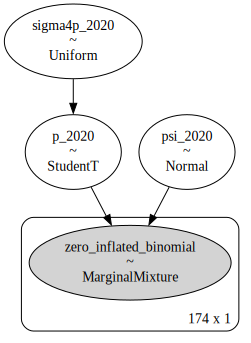

In [19]:
# Show the graphviz diagram of the structure of our single hierachy model
pm.model_to_graphviz(win_rate_2020_model)

## Step 4: sampling

In [20]:
with win_rate_2020_model:
    trace_2020=pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi_2020, sigma4p_2020, p_2020]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 63 seconds.


Let's graph the samplys:

array([[<AxesSubplot: title={'center': 'psi_2020'}>,
        <AxesSubplot: title={'center': 'psi_2020'}>],
       [<AxesSubplot: title={'center': 'p_2020'}>,
        <AxesSubplot: title={'center': 'p_2020'}>],
       [<AxesSubplot: title={'center': 'sigma4p_2020'}>,
        <AxesSubplot: title={'center': 'sigma4p_2020'}>]], dtype=object)

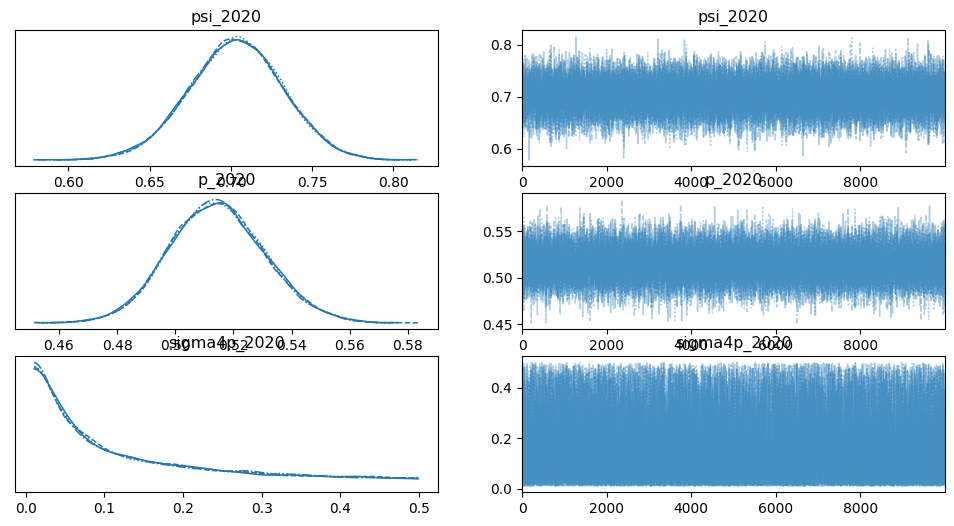

In [21]:
az.plot_trace(trace_2020)

<AxesSubplot: >

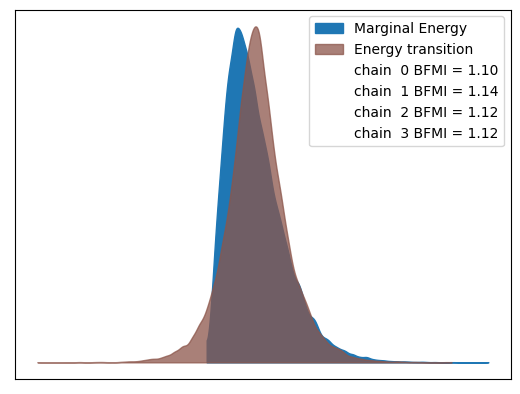

In [22]:
az.plot_energy(trace_2020)

The Hamiltonian plot showes that the simulated result resembles the original data (the win rate) well. </br>
On this basis, we will be able to do some prediction.</br>
In 2020, The Wimbledon championship was cancelled due to COVID-19 pandemic. We wonder who will mostly be the winner of Wimbledon Championship if it were not cancelled.</br>

In [32]:
url_atp_matches_2021="https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2021.csv"
df_single_2021 = pd.read_csv(url_atp_matches_2021)
print(f'There are {len(df_single_2021)} games in 2021 all games.')
df_single_Wimbledon_2021=df_single_2021[df_single_2021['tourney_name']=='Wimbledon']
print(f'There are {len(df_single_Wimbledon_2021)} games in 2021 Wimbledon.')

There are 2733 games in 2021 all games.
There are 127 games in 2021 Wimbledon.


## Bibliography


#### about Data Science </br>
Exploratory Data Analysis with R    
https://medium.com/@tobikasali/exploratory-data-analysis-with-r-f0b0a5163ecd     


Utilizing Data to Predict Winners of Tennis Matches    
https://nycdatascience.com/blog/student-works/utilizing-data-to-predict-winners-of-tennis-matches/     

Adult Tournament Information   
https://www.usta.com/en/home/play/adult-tennis/programs/eastern/adult-tennis-tournament-information-and-regulations.html    

pandas.merge_asof    
https://pandas.pydata.org/docs/reference/api/pandas.merge_asof.html    


pymc.ZeroInflatedBinomial    
https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.ZeroInflatedBinomial.html    

statsmodels    
https://www.statsmodels.org/stable/index.html    


#### about Tennis</br>

JeffSackmann / tennis_atp </br>
https://github.com/JeffSackmann/tennis_atp</br>

Welcome to US Open 101: a USOpen.org guide to how tennis works.</br>
https://www.usopen.org/en_US/us-open-at-home/how_tennis_works_us_open_101.html</br>

Wimbledon tennis tournament canceled amid coronavirus pandemic</br>
https://www.cnn.com/2020/04/01/tennis/wimbledon-canceled-coronavirus-2020-spt-intl/index.html</br>

Novak Djokovic knocked out of Wimbledon by Sam Querrey</br>
https://www.theguardian.com/sport/2016/jul/02/novak-djokovic-knocked-out-wimbledon-sam-querrey</br>